https://github.com/simpeg/em-notebooks/blob/master/notebooks/FDEM_vmd_sounding_over_sphere.ipynb

https://em.geosci.xyz/content/maxwell4_tdem/footprint_and_depth_of_investigation.html

In [98]:
from discretize import TreeMesh, TensorMesh
from discretize.utils import refine_tree_xyz, active_from_xyz

from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

from geoana.em.tdem import vertical_magnetic_field_horizontal_loop, vertical_magnetic_flux_horizontal_loop

import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import constants

#%matplotlib widget

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

In [99]:
def peak_time(depth, conductivity, mu=constants.mu_0):
    """
    Compute peak time following TDEM diffussion formula
    """
    return 1 / 6 * mu * conductivity * depth**2

def peak_depth(time, conductivity, mu=constants.mu_0):
    """
    Compute peak depth following TDEM diffussion formula
    """
    return np.sqrt(2 * time / mu / conductivity)

Define survey

1 Trasmiter and 1 resivers in the center of the loop

In [100]:
# Defining transmitter locations = (0,0,0)
x, y, z = 0, 0, 0
source_location = np.array([x, y, z])
source_radius = 10  # source loop radius
source_orientation = "z" 
source_current = 1.0  # maximum on-time current


# Define the source waveform. Define a unit step-off.
off_time = 1e-5
waveform = tdem.sources.StepOffWaveform(off_time)

# Observation times for response (time channels)
time_channels = np.logspace(-5, 1, 31)

# Define receiver list. They location is along the x-axis 
receiver_list = []
receiver_orientation = "z"  # "x", "y" or "z"
receiver_list.append(
        tdem.receivers.PointMagneticFluxDensity(
        np.array([0, 0, 0]), time_channels, orientation=receiver_orientation
    )
)

# Define source list
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

Design mesh and simulation

In [101]:
# Conductivity in S/m 
air_conductivity = 1e-8
background_conductivity = 1e-1


In [102]:
min_simulation_time = off_time
max_simulation_time = 1e-0

Compute minimum and maximum diffusion distances

In [103]:
min_diffusion_distance = min(
    peak_depth(min_simulation_time, background_conductivity),
    peak_depth(min_simulation_time, air_conductivity),
) 

max_diffusion_distance = min(  # if I use the maximum I get crazy large values, I'll go with the min then
    peak_depth(max_simulation_time, background_conductivity),
    peak_depth(max_simulation_time, air_conductivity),
)

min_diffusion_distance, max_diffusion_distance

(12.615662606666971, 3989.4228029284545)

In [104]:
# Estimate smallest cell size as 10% of the smallest diffusion distance

smallest_cell_size = 0.1 * min_diffusion_distance
smallest_cell_size

1.2615662606666973

In [105]:
cell_size = 1    # minimum cell size
x_length = 110.0  # domain width in x
y_length = 50.0
# Compute number of base mesh cells required
nbcx = 2 ** int(np.round(np.log(x_length / cell_size) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / cell_size) / np.log(2.0)))
print(nbcx, nbcy)

# Define the base mesh
hx = [(cell_size, nbcx)]
hy = [(cell_size, nbcy)]

mesh = TreeMesh([hx, hy, hx], x0="CCC")
# Refine to largest possible cell size
mesh.refine(3, finalize=False)


# Define topography and refine 
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = 0 * np.ones_like(xx)
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Refine mesh
mesh.refine_surface(topo, -1, 
                    padding_cells_by_level=3, 
                    pad_up=0, 
                    #pad_down=5
                   )
mesh.finalize()

# Set active cells and define unit values
ind_active = active_from_xyz(mesh, topo)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model for cells under the surface topography
model = background_conductivity * np.ones(ind_active.sum())


128 64


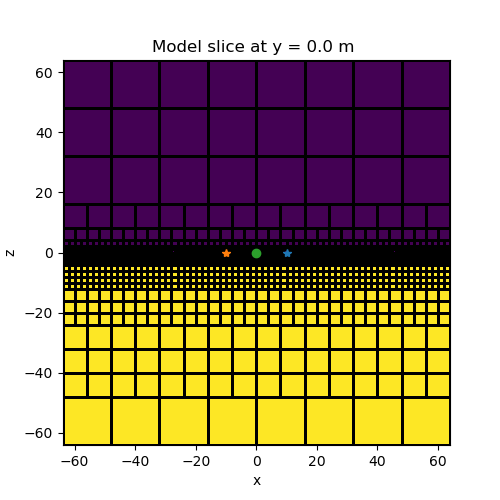

In [106]:
fig, ax = plt.subplots(figsize=(5, 5))
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal='y', ax=ax, grid=True, ind=ind_slice)
ax.set_title(f"Model slice at y = {mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice])} m ")
plt.plot(source_radius, 0, '*')
plt.plot(-source_radius, 0, '*')
plt.plot(receiver_list[0].locations[0][0], 0* np.ones_like(receiver_list[0]), 'o')
plt.show()

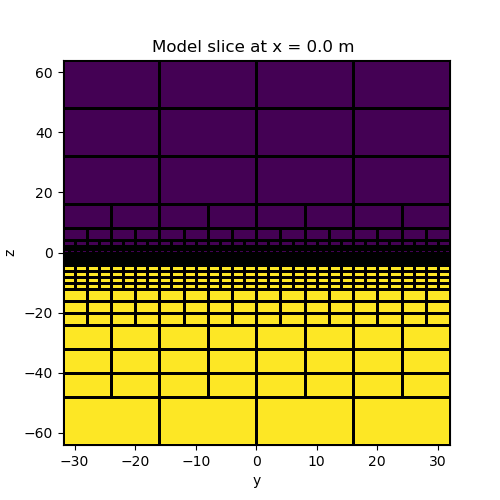

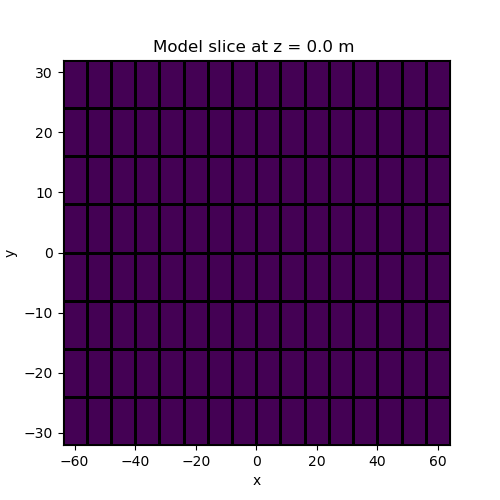

In [107]:
# Plot

for ni, axi in enumerate(['x', 'z']):
    fig, ax = plt.subplots(figsize=(5, 5))
    ind_slice = int(mesh.h[ni].size / 2)
    mesh.plot_slice(model_map * model, normal=axi, ax=ax, grid=True, 
                    ind=ind_slice
                   )
    ax.set_title(f"Model slice at {axi} = {mesh.x0[ni] + np.sum(mesh.h[ni][0:ind_slice])} m ")
    plt.show()



In [43]:
mesh

OcTreeMesh: 5.92% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       128            ---------------------------   --------------------
  4   :       512         x:     -64.0    ,    64.0           1.0    ,    16.0   
  5   :      2048         y:     -32.0    ,    32.0           1.0    ,    16.0   
  6   :      10240        z:     -64.0    ,    64.0           1.0    ,    16.0   
  7   :      49152     
-----------------------
Total :      62080

Simulation:

In [78]:
time_steps = [
            (1e-5, 20),
            (5e-5, 5),
            (1e-4, 10),
            (1e-3, 10),
            (5e-3, 10),
            (5e-2, 10),
            (1e-2, 10),
            (1e-1, 5),
            (1e-0, 9),
             ]

simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, solver=Solver
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps


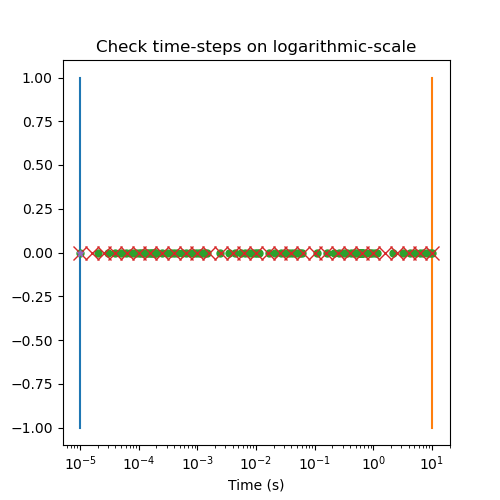

Min/max times    : 1.0e-05 / 1.0e+01
Min/max timeSteps: 1.0e-05 / 1.0e+01


In [108]:
# Logarithmic scale
# Create mesh with time steps
ts = TensorMesh([time_steps]).nodes_x


fig, ax = plt.subplots(figsize=(5, 5))
plt.title("Check time-steps on logarithmic-scale")
plt.plot([time_channels.min(), time_channels.min()], [-1, 1])
plt.plot([time_channels.max(), time_channels.max()], [-1, 1])

plt.plot(ts, ts * 0, ".", ms=10)
plt.plot(time_channels, time_channels*0, "x", ms=10)
plt.plot(off_time, off_time * 0, "*", ms=5)
plt.xscale("log")
plt.xlabel("Time (s)")
plt.show()

# Check times with time-steps
print(f"Min/max times    : {time_channels.min():.1e} / {time_channels.max():.1e}")
print(f"Min/max timeSteps: {ts[1]:.1e} / {ts[-1]:.1e}")

In [80]:
# Data are organized by transmitter, then by receiver then by observation time.
start = time.time()
dpred = simulation.dpred(model)
end = time.time()

print(f"Elapsed time: {end - start:.2f}s")


Elapsed time: 44.23s


In [81]:
dpred


array([6.31287279e-08, 3.26090766e-08, 6.81954671e-09, 1.18793244e-09,
       3.16753881e-10, 7.61162854e-11, 1.38068834e-11, 1.98397391e-12,
       1.97116405e-13, 4.34940548e-14, 3.60587811e-14, 3.59911520e-14,
       3.59907668e-14, 3.59903742e-14, 3.59897630e-14, 3.59887998e-14,
       3.59865178e-14, 3.59825051e-14, 3.59761519e-14, 3.59637397e-14,
       3.58949118e-14, 3.57859847e-14, 3.56138354e-14, 3.53421175e-14,
       3.48550927e-14, 3.46825911e-14, 2.65918512e-14, 1.34903586e-14,
       7.24203113e-15, 3.96134777e-15, 2.15746781e-15])

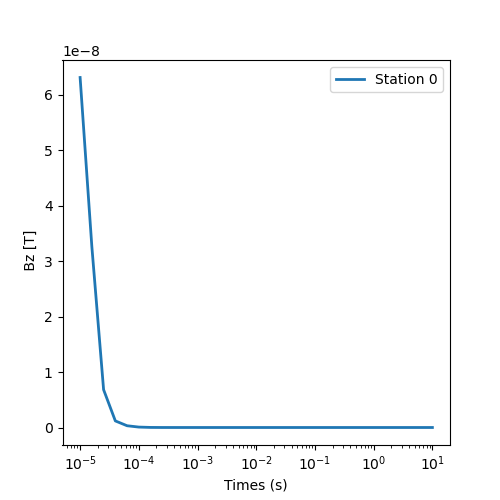

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(time_channels, dpred, lw=2, label=f'Station {0}')

ax.set_xscale('log')
ax.set_xlabel("Times (s)")
ax.set_ylabel(' Bz [T]')
#plt.plot([ts.min(), ts.min()], [-1, 1])
#plt.plot([ts.max(), ts.max()], [-1, 1])
plt.legend()
plt.show()

In [110]:
hz = vertical_magnetic_flux_horizontal_loop(
    time_channels-time_channels[0], sigma=background_conductivity, radius=source_radius, current=source_current
)
hz

array([6.28318531e-08, 5.95819884e-09, 1.64014539e-09, 6.18423502e-10,
       2.65318510e-10, 1.21473646e-10, 5.76571347e-11, 2.79492922e-11,
       1.37212955e-11, 6.78882254e-12, 3.37508844e-12, 1.68298627e-12,
       8.40801318e-13, 4.20551935e-13, 2.10508161e-13, 1.05419683e-13,
       5.28083658e-14, 2.64584628e-14, 1.32579826e-14, 6.64389103e-15,
       3.32957083e-15, 1.66865522e-15, 8.36284835e-16, 4.19131744e-16,
       2.10065893e-16, 1.05297243e-16, 5.27736268e-17, 2.64582450e-17,
       1.32576951e-17, 6.62884755e-18, 3.40014163e-18])

In [111]:
dpred

array([6.31287279e-08, 3.26090766e-08, 6.81954671e-09, 1.18793244e-09,
       3.16753881e-10, 7.61162854e-11, 1.38068834e-11, 1.98397391e-12,
       1.97116405e-13, 4.34940548e-14, 3.60587811e-14, 3.59911520e-14,
       3.59907668e-14, 3.59903742e-14, 3.59897630e-14, 3.59887998e-14,
       3.59865178e-14, 3.59825051e-14, 3.59761519e-14, 3.59637397e-14,
       3.58949118e-14, 3.57859847e-14, 3.56138354e-14, 3.53421175e-14,
       3.48550927e-14, 3.46825911e-14, 2.65918512e-14, 1.34903586e-14,
       7.24203113e-15, 3.96134777e-15, 2.15746781e-15])

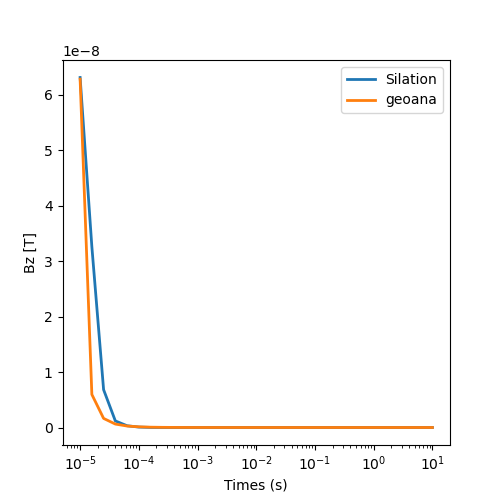

In [113]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(time_channels, dpred, lw=2, label='Silation')
ax.plot(time_channels, hz, lw=2,label='geoana')

ax.set_xscale('log')
ax.set_xlabel("Times (s)")
ax.set_ylabel('Bz [T]')
plt.legend()
plt.show()